In [ ]:
import string

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import os

# Utils

In [ ]:
def find_files(path, ext):
    files = []
    for file in os.listdir(path):
        if file.endswith(ext):
            files.append(file)
    return files

In [ ]:
from typing import Iterable, Union

def get_most_impacting(report: dict, n=2):
    """
    Get the most impacting tokens from experiments.

    Args:
        report (dict): The input dictionary containing experiment data >> dict_keys(['idx', 'tokens', 'importance', 'logits', 'predicted_label', 'true_label'])
        n (int, optional): The number of tokens to consider. Defaults to 2.

    Returns:
        dict: A dictionary containing analysis results.
    """
    _report = {
        "predict": dict(),
        "true": dict(),
        "at_all": dict(),
    }
    for pred, true, importance, tokens in zip(
        report["predicted_label"],
        report["true_label"],
        report["importance"],
        report["tokens"]
    ):

        _iter_pred = zip(np.array(tokens), importance[pred])
        data_pred = sorted([(token, importance) for token, importance in _iter_pred],
                           key= lambda x: x[1],
                           reverse=True)
        data_pred = data_pred[:n]

        if pred==true:
            data_true = data_pred.copy()
            data_all = data_pred.copy()
        else:
            _iter_true = zip(np.array(tokens), importance[true])
            data_true = sorted([(token, importance) for token, importance in _iter_true],
                               key= lambda x: x[1],
                               reverse=True)
            data_true = data_true[:n]

            data_all = sorted(data_true + data_pred,
                              key= lambda x: x[1],
                              reverse=True)
            data_all = data_all[:n]

        for p, t, a in zip(data_pred, data_true, data_all):
            if p[1] > 0:
                _report["predict"][p[0]] = _report["predict"].get(p[0], 0) + p[1]
            if t[1] > 0:
                _report["true"][t[0]] = _report["true"].get(t[0], 0) + t[1]
            if a[1] > 0:
                _report["at_all"][a[0]] = _report["at_all"].get(a[0], 0) + a[1]
            
    return {
        "predict": sorted(_report["predict"].items(), key=lambda x: x[1], reverse=True)[:n],
        "true": sorted(_report["true"].items(), key=lambda x: x[1], reverse=True)[:n],
        "at_all": sorted(_report["at_all"].items(), key=lambda x: x[1], reverse=True)[:n],
    }


def get_importance(report: dict, d_tokens: Iterable):
    _report = {}
    for dt in d_tokens:
        _report[dt] = {
            "tp": list(),
            "tn": list(),
            "fp": list(),
            "fn": list(),
            "pl": list(),
            "nl": list(),
        }
    for pred, true, importance, tokens in zip(
        report["predicted_label"],
        report["true_label"],
        report["importance"],
        report["tokens"]
    ):
        for token, importance in zip(tokens, importance):
            token = token.replace('##', '').replace('Ġ', '')
            for dt in d_tokens:
                if dt == token:
                    _report[dt]["pl"].append(importance[1])
                    _report[dt]["nl"].append(importance[0])

            if pred==true:
                if pred > 0:
                    for dt in d_tokens:
                        if dt == token:
                            _report[dt]["tp"].append(importance[1])
                else:
                    for dt in d_tokens:
                        if dt == token:
                            _report[dt]["tn"].append(importance[0])
            else:
                if pred > 0:
                    for dt in d_tokens:
                        if dt == token:
                            _report[dt]["fp"].append(importance[1])
                else:
                    for dt in d_tokens:
                        if dt == token:
                            _report[dt]["fn"].append(importance[0])

    return _report

In [ ]:
def get_importance_all(report: dict, metric_function=np.mean, split=True):
    _report = {}

    for pred, true, importance, tokens in zip(
        report["predicted_label"],
        report["true_label"],
        report["importance"],
        report["tokens"]
    ):
        for token, importance in zip(tokens, importance):
            if token not in _report:
                _report[token] = {
                    "pl": list(),
                    "nl": list(),
                }

            _report[token]["pl"].append(importance[1])
            _report[token]["nl"].append(importance[0])

    # Calculate the metric for each token and store them in a list of tuples
    pl_metrics, nl_metrics = [], []
    for token, values in _report.items():
        pl_metrics.append((token, metric_function(values["pl"])))
        nl_metrics.append((token, metric_function(values["nl"])))

    # Sort the list of tuples by the metric value
    pl_metrics = sorted(pl_metrics, key=lambda x: x[1], reverse=True)
    nl_metrics = sorted(nl_metrics, key=lambda x: x[1], reverse=True)

    if split:
        pl_metrics = pl_metrics[:NUMBER_OF_IMPORTANT_BAR]
        nl_metrics = nl_metrics[:NUMBER_OF_IMPORTANT_BAR]

    return {
        "pl": pl_metrics,
        "nl": nl_metrics,
    }


In [ ]:
def get_most_popular(report: dict, n=2):
    _report = {
        "predict": dict(),
        "true": dict(),
        "at_all": dict(),
    }
    for pred, true, importance, tokens in zip(
        report["predicted_label"],
        report["true_label"],
        report["importance"],
        report["tokens"]
    ):

        _iter_pred = zip(np.array(tokens), importance[pred])
        data_pred = sorted([(token, importance) for token, importance in _iter_pred],
                           key= lambda x: x[1],
                           reverse=True)
        data_pred = data_pred[:n]

        if pred==true:
            data_true = data_pred.copy()
            data_all = data_pred.copy()
        else:
            _iter_true = zip(np.array(tokens), importance[true])
            data_true = sorted([(token, importance) for token, importance in _iter_true],
                               key= lambda x: x[1],
                               reverse=True)
            data_true = data_true[:n]

            data_all = sorted(data_true + data_pred,
                              key= lambda x: x[1],
                              reverse=True)
            data_all = data_all[:n]

        for p, t, a in zip(data_pred, data_true, data_all):
            if p[1] > 0:
                _report["predict"][p[0]] = _report["predict"].get(p[0], 0) + 1
            if t[1] > 0:
                _report["true"][t[0]] = _report["true"].get(t[0], 0) + 1
            if a[1] > 0:
                _report["at_all"][a[0]] = _report["at_all"].get(a[0], 0) + 1

    return {
        "predict": sorted(_report["predict"].items(), key=lambda x: x[1], reverse=True)[:n],
        "true": sorted(_report["true"].items(), key=lambda x: x[1], reverse=True)[:n],
        "at_all": sorted(_report["at_all"].items(), key=lambda x: x[1], reverse=True)[:n],
    }


In [ ]:
def read_report(path):
    report = np.load(path, allow_pickle=True).item()
    report["tokens"] = [[token.replace('##', '').replace('Ġ', '') for token in tokens ]for tokens in report["tokens"]]
    return report


# Analysis

In [ ]:
BASE_PATH = "."
DATASET_NAME = "sst2"
EXPERIMENTS_PATH = os.path.join(BASE_PATH, DATASET_NAME)

FILES = find_files(EXPERIMENTS_PATH, ".npy")

NUMBER_OF_IMPORTANT_WC = 300
NUMBER_OF_IMPORTANT_BAR = 15

DEMO = True

In [ ]:
reports = {
    file.split('.')[0]: read_report(os.path.join(EXPERIMENTS_PATH, file)) for file in FILES
}

## Word cloud

### Most important

In [ ]:
save_wc_path = os.path.join(EXPERIMENTS_PATH, "most_important")
if os.path.exists(save_wc_path):
    print("Path already exists")
else:
    os.mkdir(save_wc_path)
    print("Path created")

In [ ]:
for exp_name, report in reports.items():
    rep_imp = get_most_impacting(report, n=NUMBER_OF_IMPORTANT_WC)
    _name = f"{exp_name}_imp.png"
    path = os.path.join(save_wc_path, _name)
    fig, axs = plt.subplots(1, len(rep_imp), figsize=(4*len(rep_imp), 4))
    for i, k in enumerate(rep_imp.keys()):
        wordcloud = WordCloud(width=800, height=800, background_color="white")
        wordcloud.generate_from_frequencies(dict(rep_imp[k]))

        axs[i].imshow(wordcloud, interpolation="bilinear")
        axs[i].axis("off")

        axs[i].set_title(k)

    fig.suptitle(exp_name, fontsize=16)
    plt.tight_layout(pad=1.0)
    if DEMO:
        plt.show()
    else:
        plt.savefig(path, format="png")
    plt.close()

In [ ]:
for exp_name, report in reports.items():
    rep_imp = get_most_impacting(report, n=NUMBER_OF_IMPORTANT_BAR)
    _name = f"{exp_name}_imp_bar.png"
    path = os.path.join(save_wc_path, _name)
    fig, axs = plt.subplots(1, len(rep_imp), figsize=(6*len(rep_imp), 6))

    for i, k in enumerate(rep_imp.keys()):

        tokens = [item[0] for item in rep_imp[k]]
        freqs = [item[1] for item in rep_imp[k]]

        axs[i].bar(tokens, freqs)
        axs[i].set_title(k)
        axs[i].set_xticklabels(tokens, rotation=90, ha='center')


        axs[i].set_title(k)

    fig.suptitle(exp_name, fontsize=16)
    plt.tight_layout(pad=1.0)
    if DEMO:
        plt.show()
    else:
        plt.savefig(path, format="png")
    plt.close()


### Most popular

In [ ]:
save_mp_path = os.path.join(EXPERIMENTS_PATH, "most_popular")
if os.path.exists(save_mp_path):
    print("Path already exists")
else:
    os.mkdir(save_mp_path)
    print("Path created")

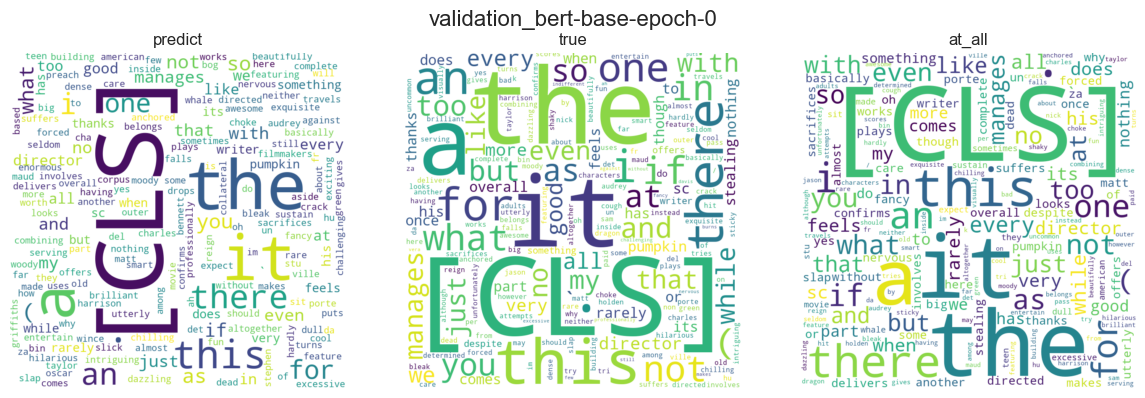

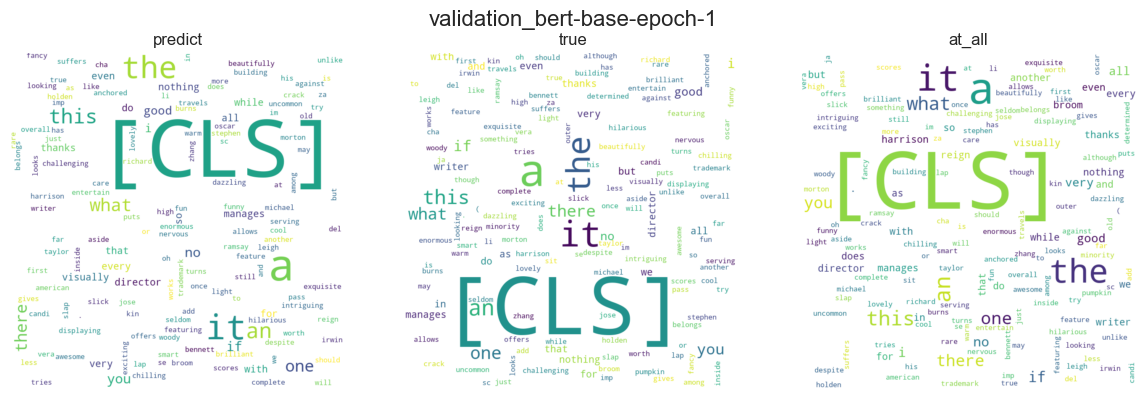

In [16]:
for exp_name, report in reports.items():
    rep_mp = get_most_popular(report, n=NUMBER_OF_IMPORTANT_WC)
    _name = f"{exp_name}_mp.png"
    path = os.path.join(save_mp_path, _name)
    fig, axs = plt.subplots(1, len(rep_mp), figsize=(4*len(rep_mp), 4))
    for i, k in enumerate(rep_mp.keys()):
        wordcloud = WordCloud(width=800, height=800, background_color="white")
        wordcloud.generate_from_frequencies(dict(rep_mp[k]))

        axs[i].imshow(wordcloud, interpolation="bilinear")
        axs[i].axis("off")

        axs[i].set_title(k)

    fig.suptitle(exp_name, fontsize=16)
    plt.tight_layout(pad=1.0)
    if DEMO:
        plt.show()
    else:
        plt.savefig(path, format="png")
    plt.close()


## for particular set of tokens

In [17]:
EXP_and_NAME = {
    # "true positive": 'tp',
    # "true negative": 'tn',
    # "false positive": 'fp',
    # "false negative": 'fn',
    # "positive predicted": 'tp+fp',
    # "negative predicted": 'tn+fn',
    "real positive": 'tp+fn',
    "real negative": 'tn+fp',
    "effect on positivity": "pl",
    "effect on negativity": "nl",
}

In [18]:
save_mp_path = os.path.join(EXPERIMENTS_PATH, "token effect")
if os.path.exists(save_mp_path):
    print("Path already exists")
else:
    os.mkdir(save_mp_path)
    print("Path created")

Path already exists


In [19]:
token_group, token_set = [
    ("punctuation", list(string.punctuation)),
    ("neutral tokens", ["a", "an", "what", "the", "you", "one", "it", "this", "movie", "i", "with", "if"]),
    ('multy type', [
        "respect", "impact", "loved"
        "a", "an", "the", "one", "it", "this",
        ".", ":", ";", "(", ")", "?",
        "killing", "stupid",
    ])
][2]

_save_mp_path = os.path.join(save_mp_path, token_group)

if not os.path.exists(_save_mp_path):
    os.mkdir(_save_mp_path)
    print("Path created")


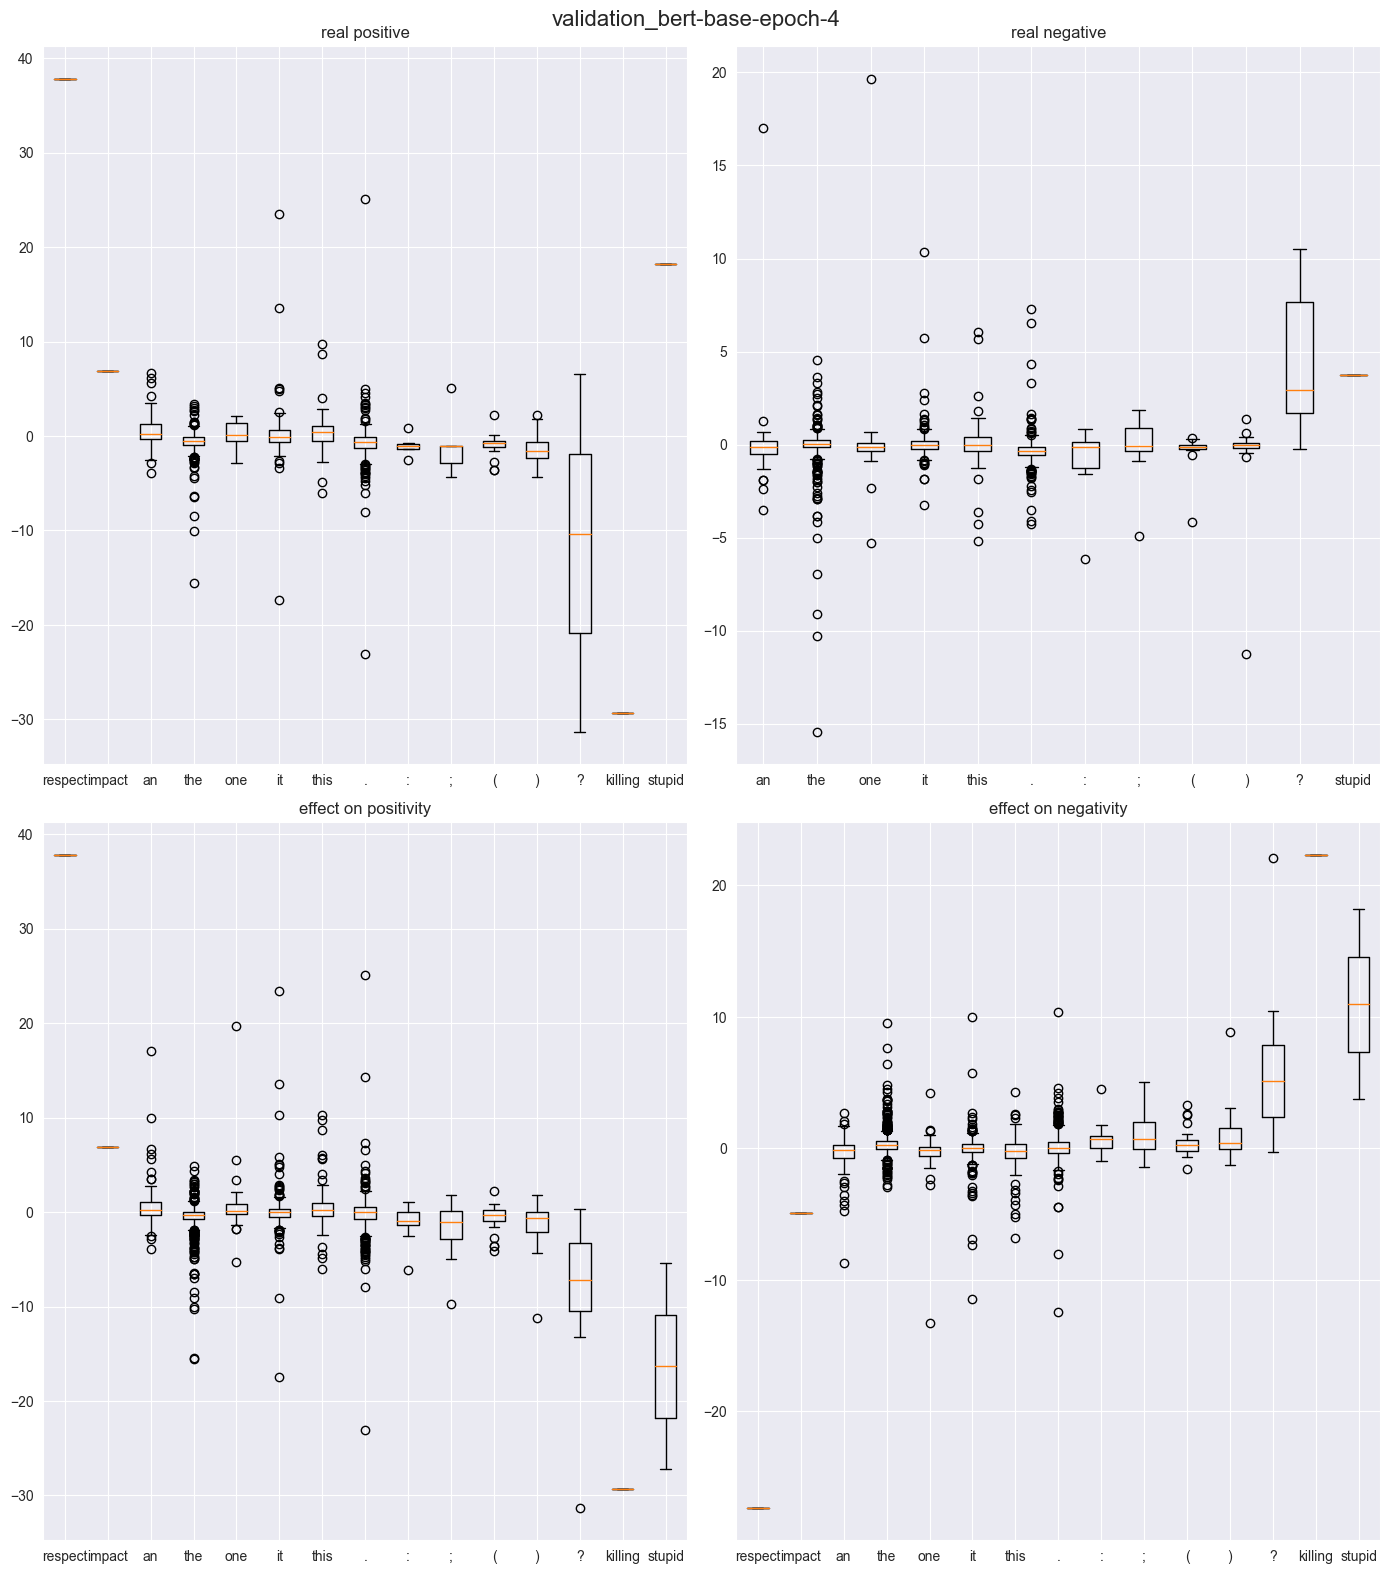

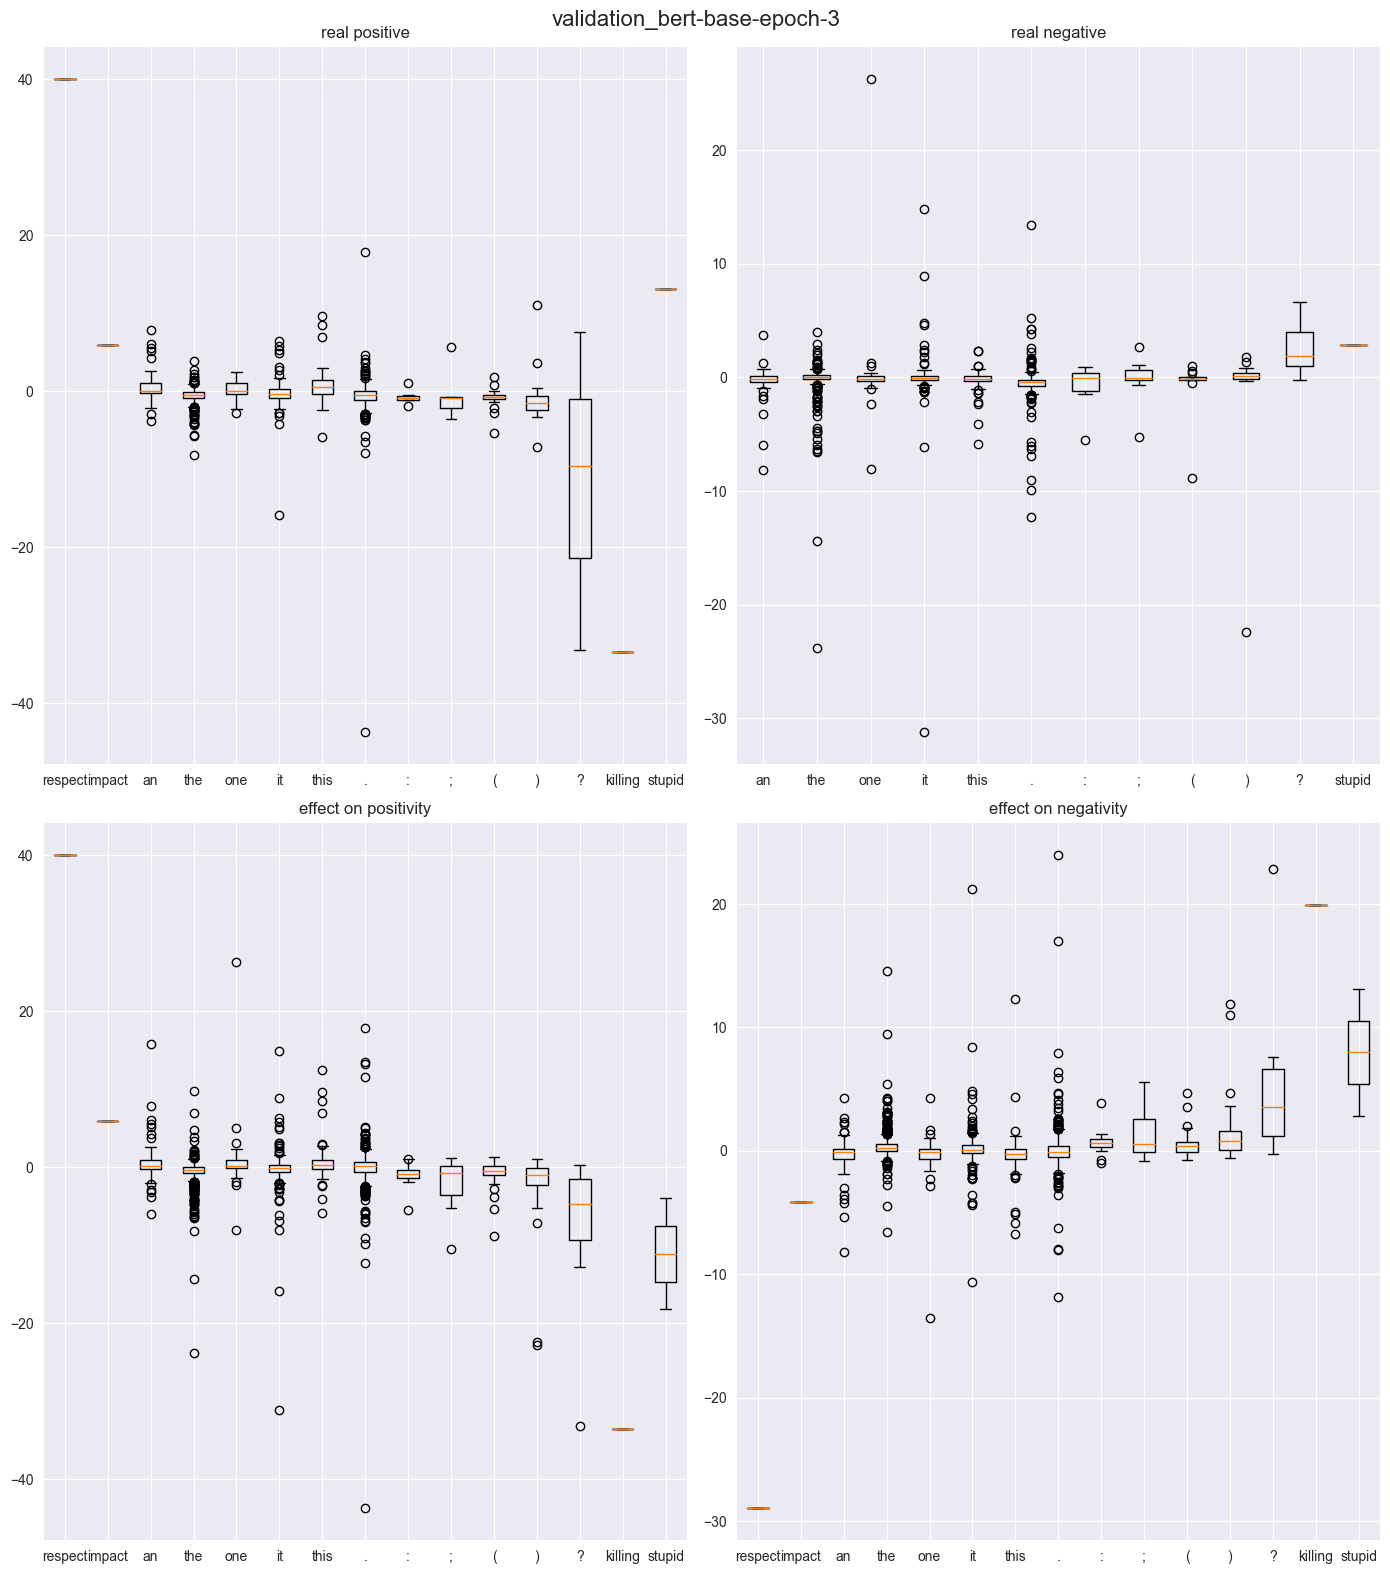

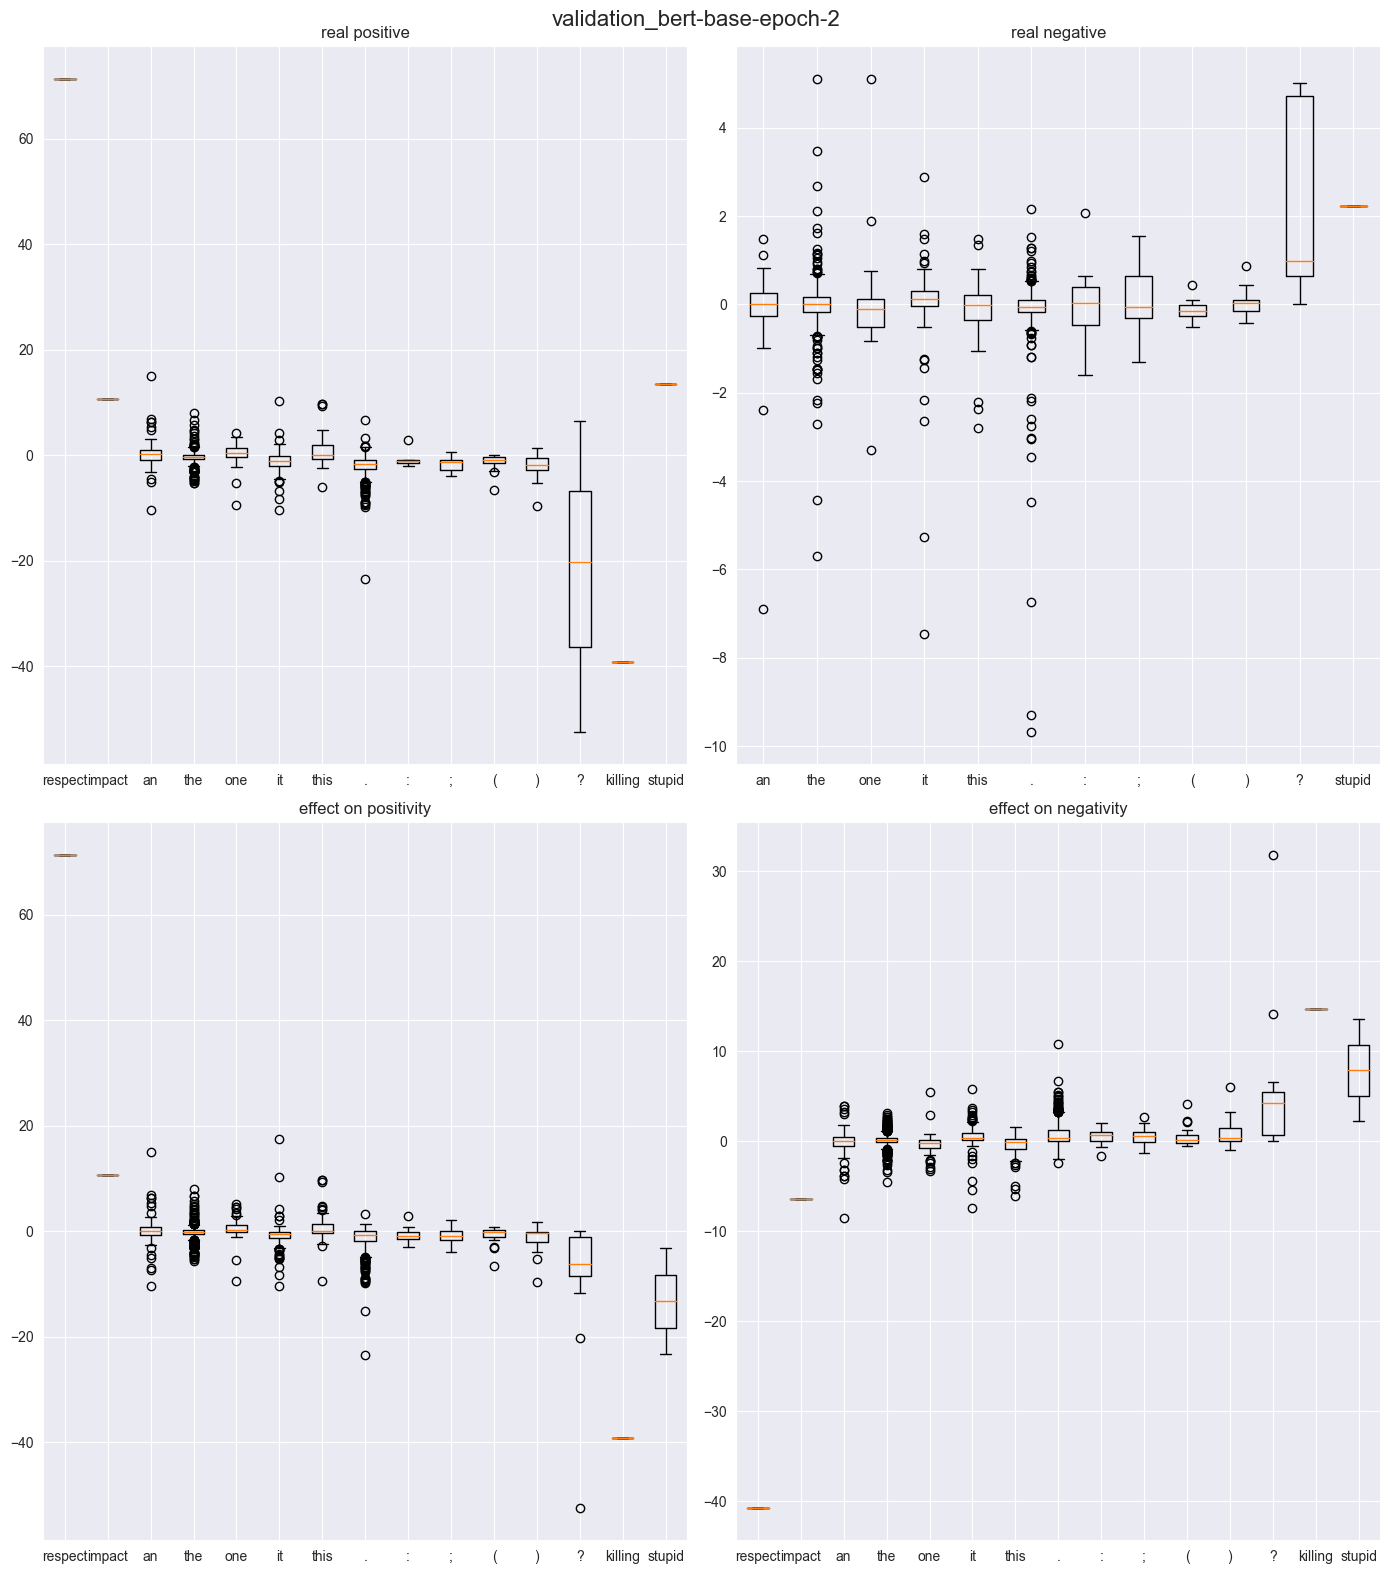

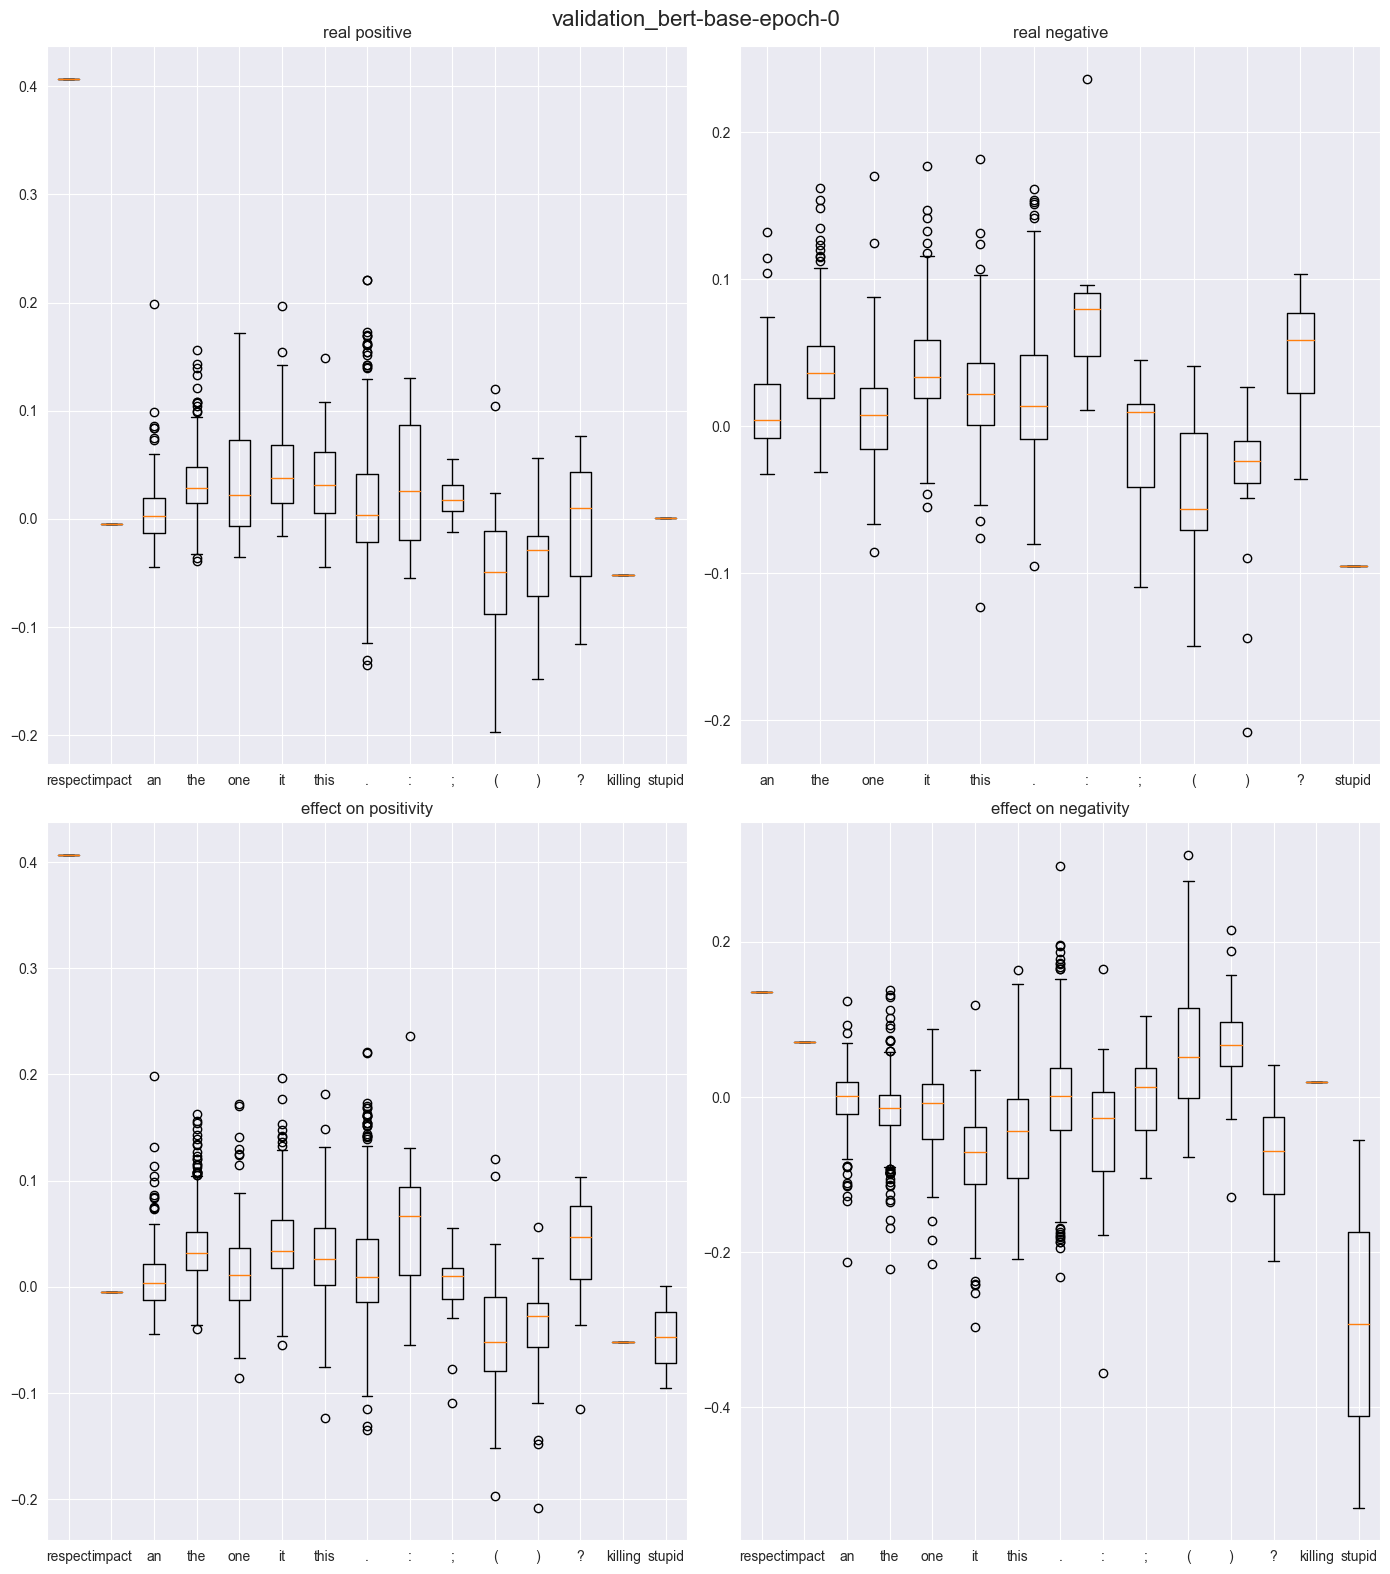

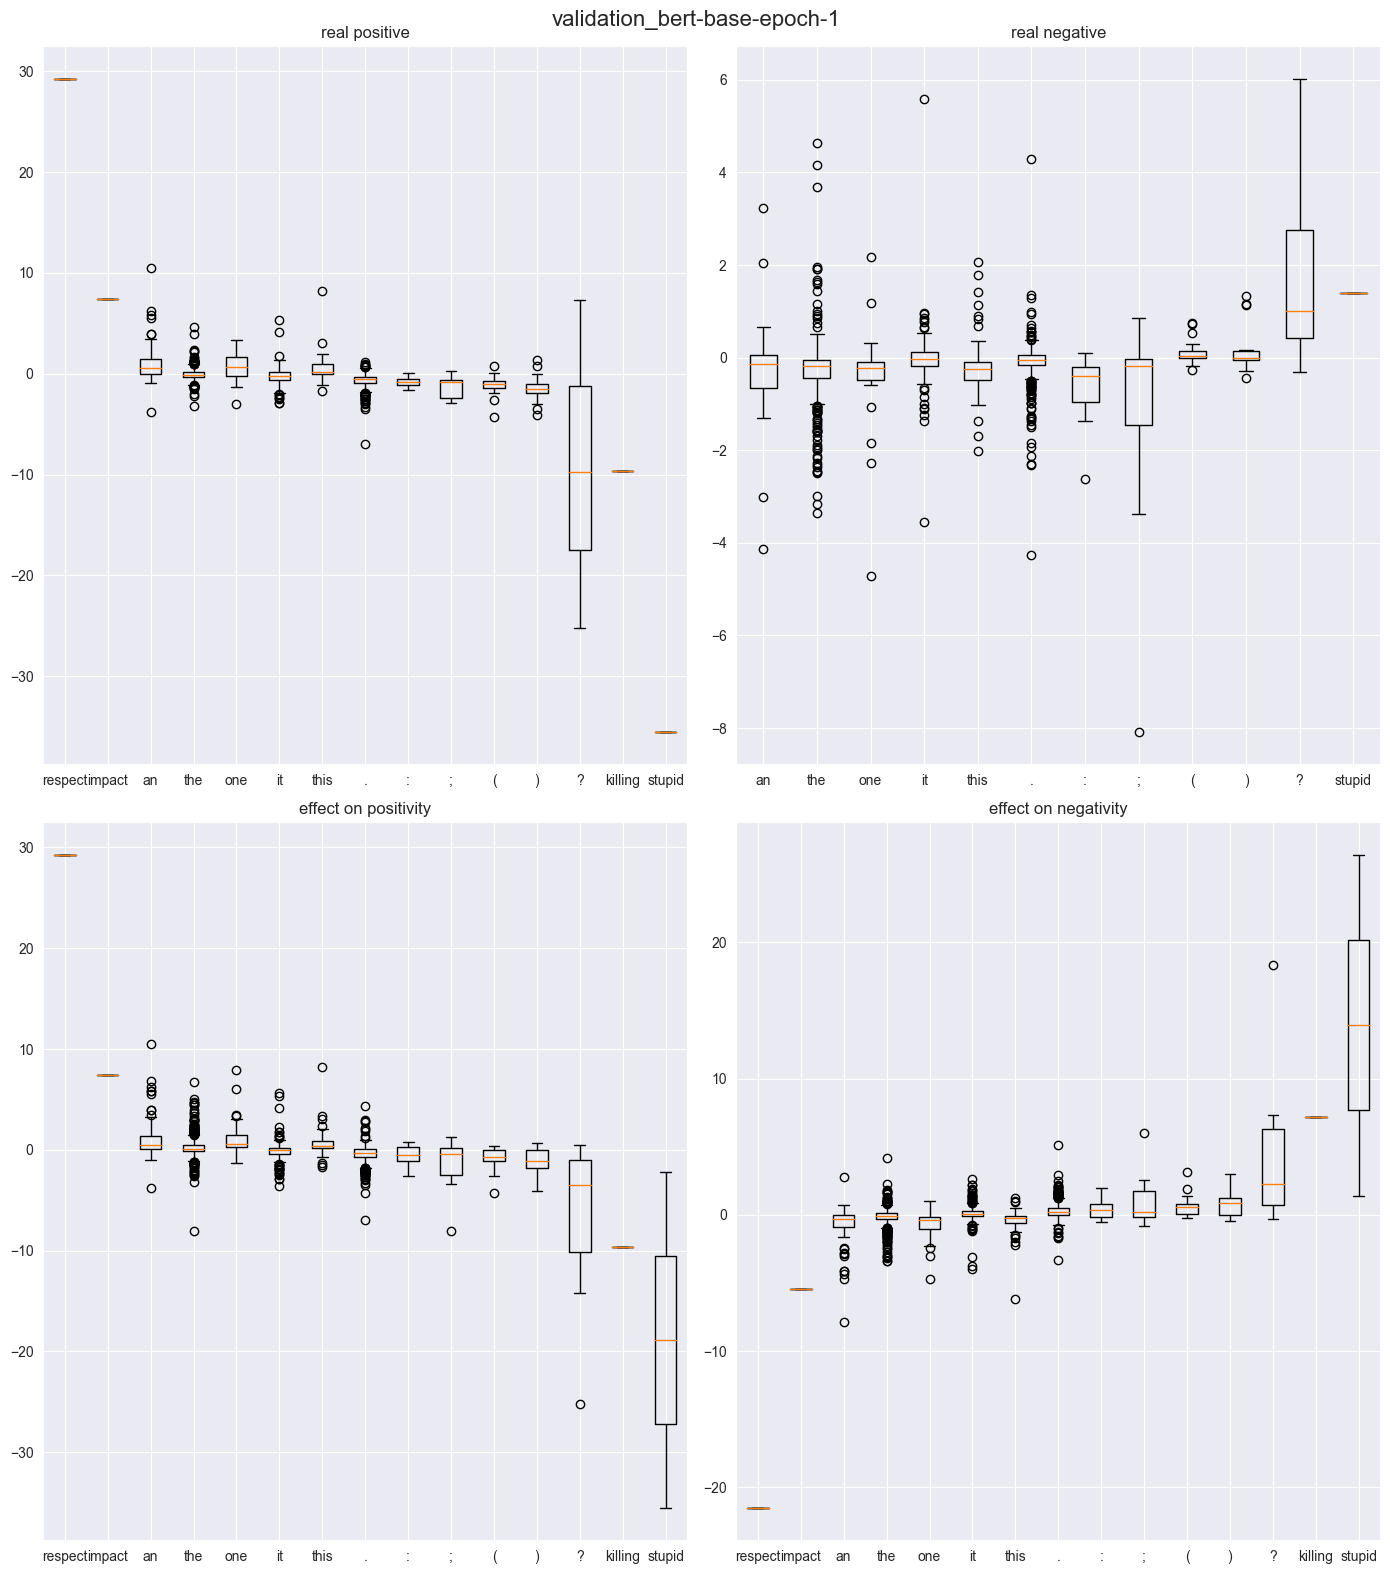

In [20]:
for exp_name, report in reports.items():
    rep_mp = get_importance(report, d_tokens=token_set)
    _name = f"{exp_name}_{token_group}.png"
    path = os.path.join(_save_mp_path, _name)
    fig, axs = plt.subplots(len(EXP_and_NAME)//2, 2, figsize=(14, 4*len(EXP_and_NAME)))

    for idx, exp in enumerate(EXP_and_NAME.keys()):
        i,j = idx//2, idx%2
        label_list = list(str(EXP_and_NAME[exp]).split('+'))
        temp_dict = dict()
        for ts in token_set:
            for l in label_list:
                if rep_mp[ts][l]:
                    temp_dict[ts] = list(temp_dict.get(ts, [])) + list(rep_mp[ts][l])

        axs[i][j].boxplot(temp_dict.values(), labels=temp_dict.keys())
        axs[i][j].set_title(exp)

    fig.suptitle(exp_name, fontsize=16)
    plt.tight_layout(pad=1.0)
    if DEMO:
        plt.show()
    else:
        plt.savefig(path, format="png")
    plt.close()

In this section, we would get importance with 'get_importance' function and then for [pl, nl], we would calculate mean for each token and plot 'NUMBER_OF_IMPORTANT_BAR' bar with most impact on that label

/var/folders/qr/bqqcrz2x32g6f0wk_w9qf8580000gn/T/ipykernel_2341/1041431682.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(tokens, rotation=90, ha='center')
/var/folders/qr/bqqcrz2x32g6f0wk_w9qf8580000gn/T/ipykernel_2341/1041431682.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(tokens, rotation=90, ha='center')


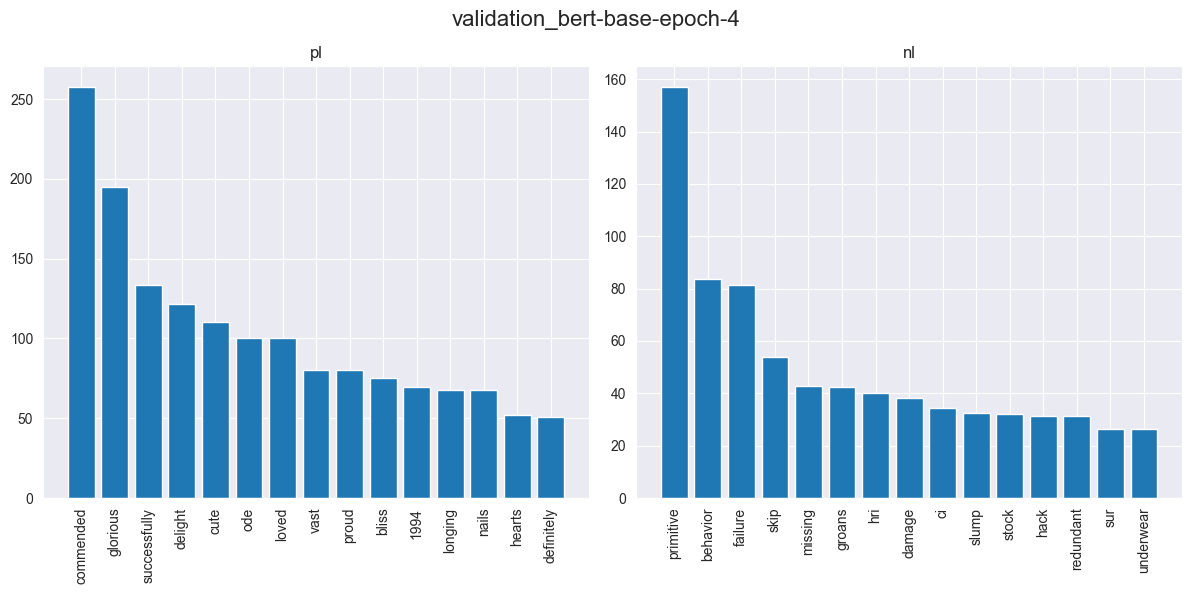

/var/folders/qr/bqqcrz2x32g6f0wk_w9qf8580000gn/T/ipykernel_2341/1041431682.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(tokens, rotation=90, ha='center')
/var/folders/qr/bqqcrz2x32g6f0wk_w9qf8580000gn/T/ipykernel_2341/1041431682.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(tokens, rotation=90, ha='center')


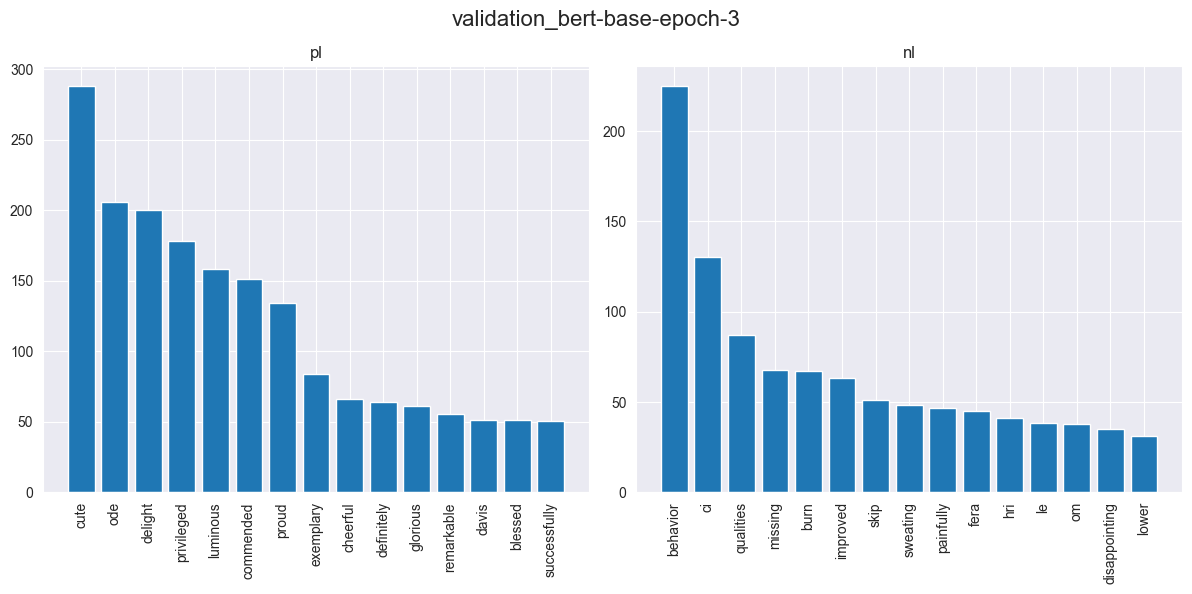

/var/folders/qr/bqqcrz2x32g6f0wk_w9qf8580000gn/T/ipykernel_2341/1041431682.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(tokens, rotation=90, ha='center')
/var/folders/qr/bqqcrz2x32g6f0wk_w9qf8580000gn/T/ipykernel_2341/1041431682.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(tokens, rotation=90, ha='center')


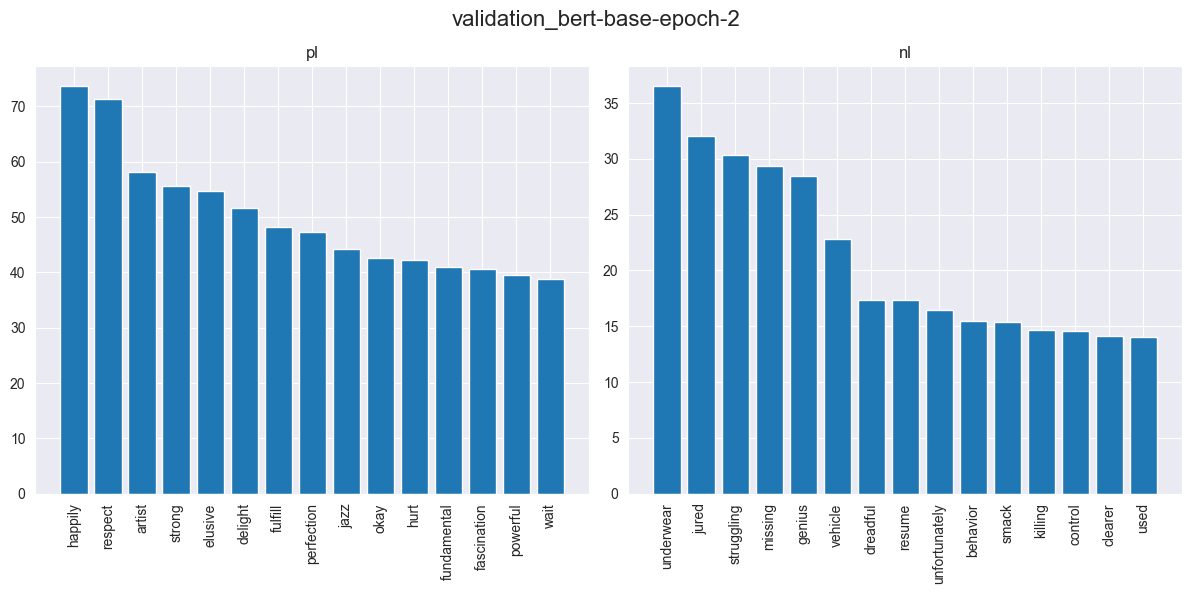

/var/folders/qr/bqqcrz2x32g6f0wk_w9qf8580000gn/T/ipykernel_2341/1041431682.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(tokens, rotation=90, ha='center')
/var/folders/qr/bqqcrz2x32g6f0wk_w9qf8580000gn/T/ipykernel_2341/1041431682.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(tokens, rotation=90, ha='center')


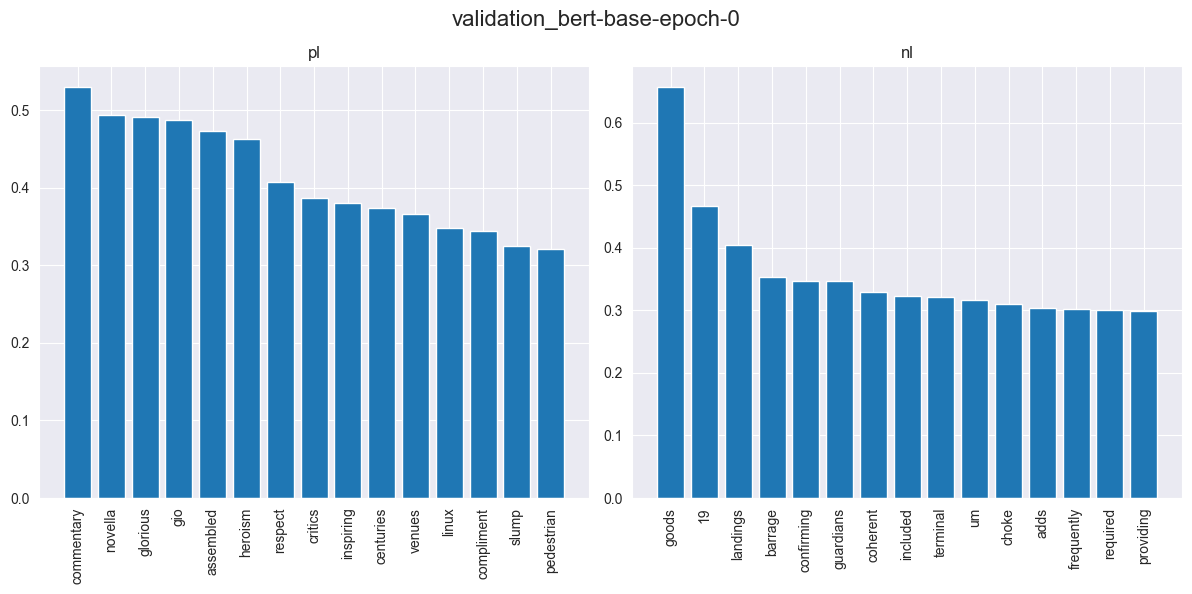

/var/folders/qr/bqqcrz2x32g6f0wk_w9qf8580000gn/T/ipykernel_2341/1041431682.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(tokens, rotation=90, ha='center')
/var/folders/qr/bqqcrz2x32g6f0wk_w9qf8580000gn/T/ipykernel_2341/1041431682.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(tokens, rotation=90, ha='center')


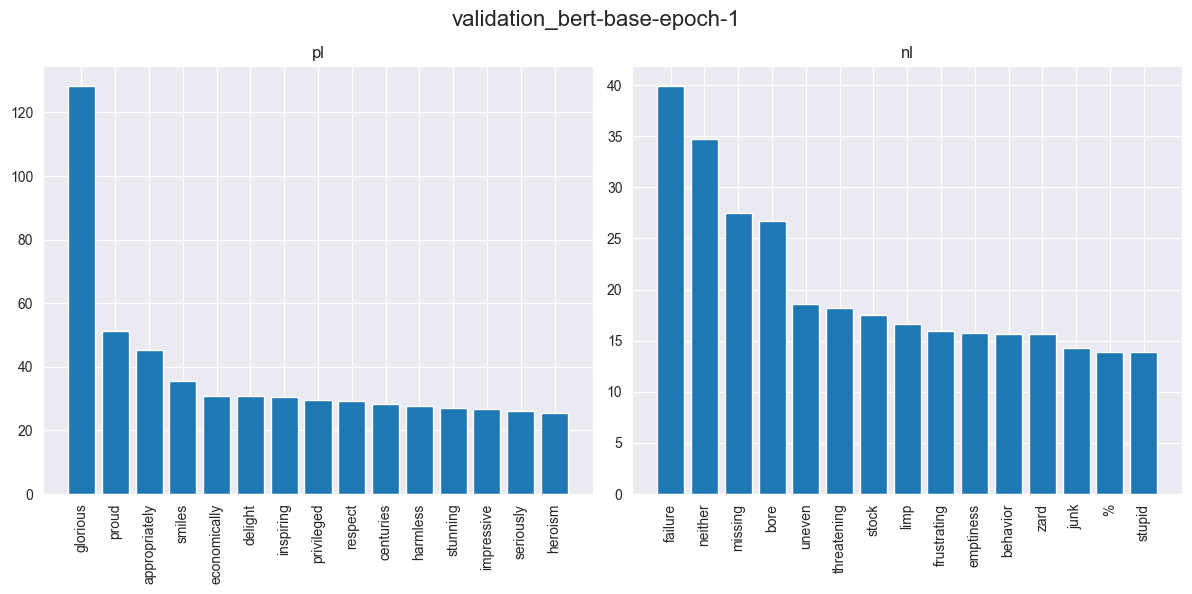

In [21]:
_save_path = os.path.join(save_mp_path, "most important aggregated")
if not os.path.exists(_save_path):
    os.mkdir(_save_path)
    print("Path created")

for exp_name, report in reports.items():
    rep_mp = get_importance_all(report, metric_function=np.mean)
    _name = f"{exp_name}_aggr_bar.png"
    path = os.path.join(_save_path, _name)
    fig, axs = plt.subplots(1, len(rep_mp), figsize=(6*len(rep_mp), 6))

    for i, k in enumerate(rep_mp.keys()):
        tokens = [item[0] for item in rep_mp[k]]
        freqs = [item[1] for item in rep_mp[k]]

        axs[i].bar(tokens, freqs)
        axs[i].set_title(k)
        axs[i].set_xticklabels(tokens, rotation=90, ha='center')

        axs[i].set_title(k)

    fig.suptitle(exp_name, fontsize=16)
    plt.tight_layout(pad=1.0)
    if DEMO:
        plt.show()
    else:
        plt.savefig(path, format="png")
    plt.close()


## generate [token-mean-variance] dataset

validation_bert-base-epoch-4


,mean0,mean1,variance0,variance1
count,4326.000000,4326.000000,4326.000000,4326.000000
mean,-0.060133,0.075105,8.731451,31.253742
std,6.501721,11.331075,97.420952,450.761841
min,-140.783249,-278.347351,0.000000,0.000000
25%,-1.280248,-1.907115,0.000000,0.000000
50%,0.034117,-0.046161,0.000000,0.000000
75%,1.351108,1.795766,1.084668,2.224060
max,157.148178,257.677002,3905.622314,21934.523438


validation_bert-base-epoch-3


,mean0,mean1,variance0,variance1
count,4326.000000,4326.000000,4326.000000,4326.000000
mean,-0.087279,0.157232,28.991533,92.212868
std,8.183271,13.434590,711.922302,2636.426025
min,-150.396652,-374.112732,0.000000,0.000000
25%,-1.279370,-1.909422,0.000000,0.000000
50%,0.047590,-0.060266,0.000000,0.000000
75%,1.349156,1.780900,1.092523,2.232754
max,224.679291,287.782043,42046.464844,157164.078125


validation_bert-base-epoch-2


,mean0,mean1,variance0,variance1
count,4326.000000,4326.000000,4326.000000,4326.000000
mean,-0.188525,0.305529,3.123484,11.038285
std,3.683091,6.471570,17.308407,83.783073
min,-40.743336,-91.955757,0.000000,0.000000
25%,-1.053963,-1.657771,0.000000,0.000000
50%,0.001496,-0.008482,0.000000,0.000000
75%,1.073346,1.593593,0.757086,1.746950
max,36.479366,73.606377,467.527954,3883.757812


validation_bert-base-epoch-0


,mean0,mean1,variance0,variance1
count,4326.000000,4326.000000,4326.000000,4326.000000
mean,-0.003799,0.009773,0.002087,0.000940
std,0.093761,0.067684,0.006929,0.002791
min,-0.733833,-0.304549,0.000000,0.000000
25%,-0.047883,-0.024454,0.000000,0.000000
50%,0.001980,0.004703,0.000000,0.000000
75%,0.044776,0.039445,0.001452,0.000697
max,0.657438,0.530063,0.166511,0.047554


validation_bert-base-epoch-1


,mean0,mean1,variance0,variance1
count,4326.000000,4326.000000,4326.000000,4326.000000
mean,-0.047119,0.049748,2.663279,5.672654
std,3.295612,4.930093,34.648205,76.027199
min,-75.728714,-67.475098,0.000000,0.000000
25%,-0.752164,-1.333517,0.000000,0.000000
50%,0.041868,-0.063455,0.000000,0.000000
75%,0.927986,1.077491,0.420628,0.856525
max,39.871532,128.137711,1989.842407,4398.737793


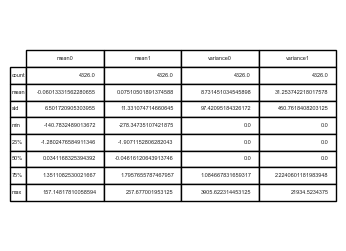

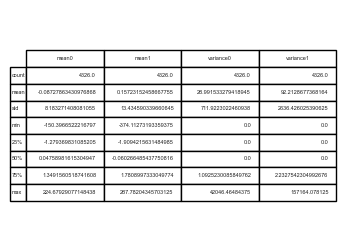

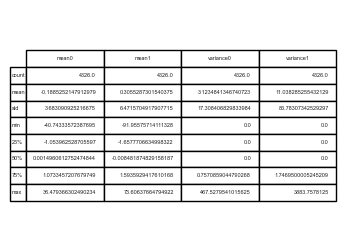

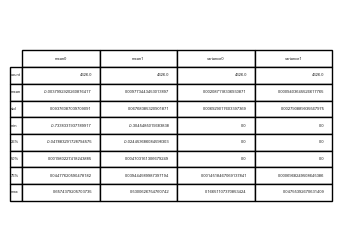

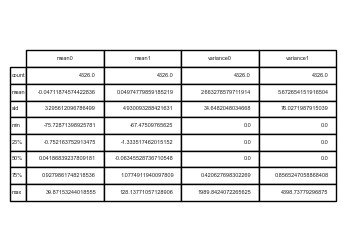

In [22]:
from IPython.display import display, HTML
from pandas.plotting import table

_trends_path = os.path.join(save_mp_path, "trends")
_save_path = _trends_path
if not os.path.exists(_trends_path):
    os.mkdir(_trends_path)
    print("Path created")

for exp_name, report in reports.items():
    rep_mp = get_importance_all(
        report,
        metric_function=np.mean,
        split=False
    )
    rep_vp = get_importance_all(
        report,
        metric_function=np.var,
        split=False
    )
    _name = f"{exp_name}.csv"
    path = os.path.join(_trends_path, _name)
    img_path = os.path.join(_trends_path, exp_name + "-desc.png")

    tokens = [token for token, _ in rep_mp['pl']]
    data = [
        {"token": token, "mean0": 0, "mean1": 0, "variance0": 0, "variance1": 0} \
        for token in tokens
    ]

    for mm1, vv1, mm0, vv0 in zip(rep_mp["pl"], rep_vp["pl"], rep_mp["nl"], rep_vp["nl"]):
        idx_v = tokens.index(vv1[0])
        idx_m = tokens.index(mm1[0])
        data[idx_v]["variance1"] = vv1[1]
        data[idx_m]["mean1"] = mm1[1]
        idx_v = tokens.index(vv0[0])
        idx_m = tokens.index(mm0[0])
        data[idx_v]["variance0"] = vv0[1]
        data[idx_m]["mean0"] = mm0[1]

    df = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.axis('off')
    table(ax, df.describe(), loc='center')

    if DEMO:
        print(exp_name)
        display((df.describe()))
        # display(HTML(df.to_html(index=False)))
    else:
        df.to_csv(path, index=False)
        plt.savefig(img_path, dpi=300, bbox_inches='tight')
        plt.close()


## Tokens with zero variance

In [23]:
DEMO = False

In [24]:
trends_db_files = sorted(find_files(_trends_path, '.csv'))
threshold = 1e-4

zero_vars: dict[set] = {}

for dbf in trends_db_files:
    name = os.path.splitext(dbf)[0]

    df = pd.read_csv(os.path.join(_trends_path, dbf))
    df = df[(df['variance0'] <= threshold) & (df['variance1'] <= threshold)]
    df.drop(columns=['variance0', 'variance1'], inplace=True)

    tokens = set(df["token"])
    zero_vars[name] = tokens

In [28]:
import json

sets_name = list(zero_vars.keys())
df = [{"set": set_name, "new inserts": len(zero_vars[set_name]), "deleted": 0, "total": len(zero_vars[set_name])} for set_name in sets_name]

changes_dataset = {
    "epoch 0" : {
        "added": list(zero_vars[sets_name[0]]),
        "deleted": []
    },
}

for idx, (prev, curr) in enumerate(zip(sets_name[:-1], sets_name[1:]), start=1):
    intersects = zero_vars[prev].intersection(zero_vars[curr])
    # common_count = len(list(intersects))
    deleted = zero_vars[prev] - intersects
    added = zero_vars[curr] - intersects

    epoch = f"epoch {idx}"
    changes_dataset[epoch] = {
        "added": list(added),
        "deleted": list(deleted),
    }

    df[idx]["new inserts"] = len(list(added))
    df[idx]["deleted"] = len(list(deleted))

df = pd.DataFrame(df)

log_path = os.path.join(_trends_path, "log.png")
change_data_path = os.path.join(_trends_path, "token_changes.json")

if DEMO:
    display(HTML(df.to_html(index=False)))
else:
    fig, ax = plt.subplots(figsize=(5, 2))
    ax.axis('off')
    plt.title("Token trends in different epochs")
    table(ax, df, loc='center')
    plt.savefig(log_path, dpi=300, bbox_inches='tight')
    plt.close()

    with open(change_data_path, 'w') as f:
        json.dump(changes_dataset, f, indent=4)
